# Imports and Downloads

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from os import listdir
from PIL import Image
import time
from sklearn.model_selection import train_test_split

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_IV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_ENB
from tensorflow.keras.applications.convnext import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as preprocess_input_CNT

from keras.preprocessing import sequence, image
from keras.models import Sequential, Model
from keras import Input, layers, optimizers
from keras.layers import LSTM, SimpleRNN, Embedding, Dense, Activation, \
                         Reshape, Flatten, Dropout, Add, GRU
from keras.optimizers import Adam
from keras.utils import pad_sequences, to_categorical, plot_model
import keras.utils as image
from keras.utils import plot_model

from collections import Counter
import spacy
import nltk.translate.bleu_score as bleu

import random



In [ ]:
# had to add this to get rid of error with wget, unless getting error about UTF-8 encoding, ignore this code block
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# download the Flickr8k dataset
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
# download spaCy embedding vectors
!python -m spacy download en_core_web_md

2023-03-12 21:02:22.146371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 21:02:22.146488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 21:02:22.146508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 7.2 MB/s 

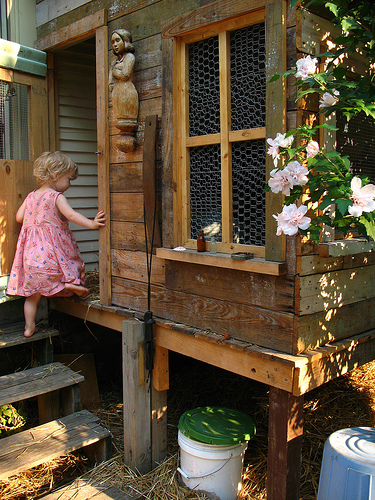

In [ ]:
# An example image
Image.open('Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

# Preprocess the Captions

In [ ]:
def cleanText(s):
  #removes punctuation and lowercases text
  transTable = str.maketrans('', '', string.punctuation)
  s = s.translate(transTable)
  s = s.lower()
  return s

def load_captions_data(filename): 
    #divides captions into dictionary based on relevant image;
    # also creates full vocab set
    capFile = open(filename)
    captionMap = {}
    vocab = set()

    for line in capFile:

      #separates data into image name and caption, cleans the both
      line = line.rstrip("\n")
      name, cap = line.split("\t")
      cap = cleanText(cap)
      name = name.split(".")[0]

      #generate vocabulary set
      for word in cap.split(): 
        if word.isalpha():
          vocab.add(word)

      #add name, caption pair to dictionary
      if name not in captionMap:
        captionMap[name] = []
      captionMap[name].append(cap)

    capFile.close()
    captionMap.pop("2258277193_586949ec62") # this image does not actually exist
    return captionMap, vocab

preprocessed_map, vocabulary = load_captions_data("Flickr8k.token.txt")
print(*preprocessed_map['1000268201_693b08cb0e'], sep='\n')
print("Vocab Size: ", len(vocabulary))

a child in a pink dress is climbing up a set of stairs in an entry way 
a girl going into a wooden building 
a little girl climbing into a wooden playhouse 
a little girl climbing the stairs to her playhouse 
a little girl in a pink dress going into a wooden cabin 
Vocab Size:  8775


# Train-Test Split

In [ ]:
#split data set into training and testing data
train_img_name, test_img_name = train_test_split(list(preprocessed_map.keys()), test_size=0.15)
print('Number of images in train data',len(train_img_name))
print('Number of images in test data',len(test_img_name))

Number of images in train data 6877
Number of images in test data 1214


In [ ]:
def load_captions(imgs):
  # returns a dictionary where:
  #   keys = image names; example: '1000268201_693b08cb0e'
  #   values = a list of the image's 5 captions, each with 'startseq' and 'endseq'
  captions = {}
  for img_id in imgs:
    img_captions = ['startseq ' + caption + 'endseq' for caption in preprocessed_map[img_id]]
    captions[img_id] = img_captions
  return captions

train_captions = load_captions(train_img_name)
test_captions = load_captions(test_img_name)

# Load Pre-Trained CNN Models

In [ ]:
def preprocess_image(img_path, model):
    img = image.load_img(img_path,target_size=(299,299)) 
    img = image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
    img = np.expand_dims(img, axis=0) # Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
    # preprocess image as specified by desired model 
    if model.name == 'inception_v3':
      img = preprocess_input_IV3(img) 
    elif model.name == 'efficientnetb0':
      img = preprocess_input_ENB(img) 
    elif model.name == 'convnext_tiny':
      img = preprocess_input_CNT(img) 
    
    return img  # shape: (1, 299, 299, 3)

In [ ]:
# Load Inception-V3 model
model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
# model_InceptionV3.summary()

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
img = preprocess_image('Flicker8k_Dataset/1000268201_693b08cb0e.jpg', model_InceptionV3)
model_InceptionV3.predict(img).shape

1/1 [==============================] - 9s 9s/step


(1, 2048)

In [ ]:
plot_model(model_InceptionV3, to_file='model_IV3.png', show_shapes=True, show_layer_names=True)

# show a visual of the model
Image.open('model_IV3.png').show()

In [ ]:
# Load EfficientNetB0 model
model_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
# model_EfficientNetB0.summary()

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
img = preprocess_image('Flicker8k_Dataset/1000268201_693b08cb0e.jpg', model_EfficientNetB0)
model_EfficientNetB0.predict(img).shape

1/1 [==============================] - 2s 2s/step


(1, 1280)

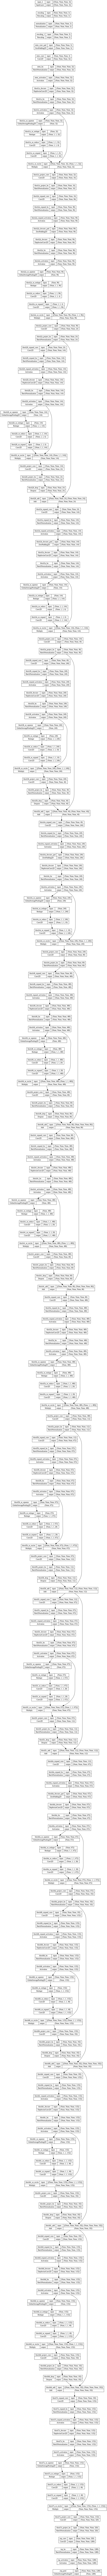

In [ ]:
plot_model(model_EfficientNetB0, to_file='model_ENB.png', show_shapes=True, show_layer_names=True)

# show a visual of the model
Image.open('model_ENB.png').show()

In [ ]:
# Load the pre-trained VGG16 model
model_ConvNeXtTiny = ConvNeXtTiny(weights='imagenet', include_top=False, pooling='avg')
# model_ConvNeXtTiny.summary()

111650432/111650432 [==============================] - 6s 0us/step


In [ ]:
img = preprocess_image('Flicker8k_Dataset/1000268201_693b08cb0e.jpg', model_ConvNeXtTiny)
model_ConvNeXtTiny.predict(img).shape

1/1 [==============================] - 5s 5s/step


(1, 768)

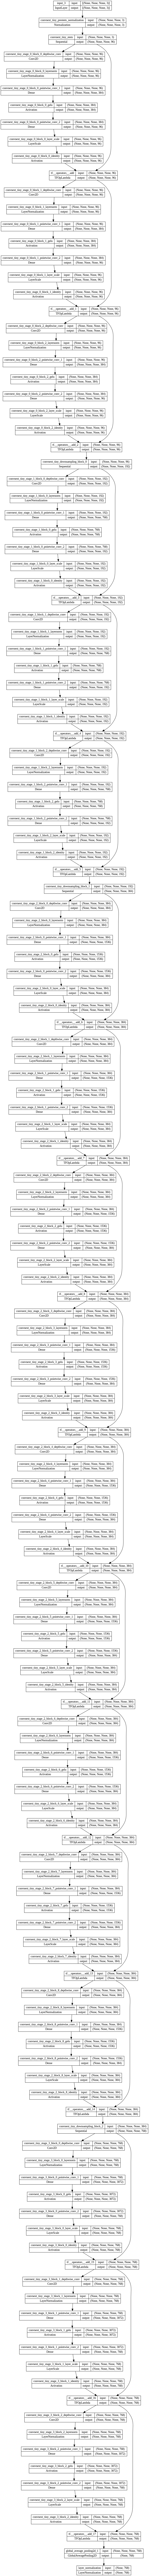

In [ ]:
plot_model(model_ConvNeXtTiny, to_file='model_CNT.png', show_shapes=True, show_layer_names=True)

# show a visual of the model
Image.open('model_CNT.png').show()

# Encode Images

#### Specify which CNN to use for image feature extraction in the cell below.

To get results (plot/accuracy/etc) for each CNN, rerun encoding portion and then train desired decoder model(s).

In [ ]:
# declare which CNN to use for encoding
# 1. model_InceptionV3
# 2. model_EfficientNetB0
# 3. model_ConvNeXtTiny

CNN = model_InceptionV3
CNN.name

'inception_v3'

In [ ]:
path = 'Flicker8k_Dataset/'
train_img_names = [path+img+'.jpg' for img in train_img_name]
test_img_names = [path+img+'.jpg' for img in test_img_name]

In [ ]:
# Function to encode given image into a feature vector
def encode_image(image, CNN):
    image = preprocess_image(image, CNN) # preprocess image
    feature_vector = CNN.predict(image, verbose=[0]) # Get encoding vector for image
    feature_vector = feature_vector.reshape(feature_vector.shape[1],) # reshape from (1,n) to (n,)
                                                                      # where n depends on which CNN
                                                                      # is being used
    return feature_vector

In [ ]:
# Slow cell to run as all 8k images are being encoded.

# To encode all train images
start_train = time.time()
encoding_train = {}
for idx,img in enumerate(train_img_names):
    # print how many images have been encoded
    if((idx+1) % 500 == 0):
        print('Train images encoded ',idx+1)
    encoding_train[img] = encode_image(img, CNN)
print("** Time taken for encoding train images {} seconds **".format(time.time()-start_train))


# To encode all test images
start_test = time.time()
encoding_test = {}
for idx,img in enumerate(test_img_names):
    # print how many images have been encoded
    if((idx+1) % 200 == 0):
        print('Test images encoded ',idx+1)
    encoding_test[img] = encode_image(img, CNN)
print("** Time taken for encoding test images {} seconds **".format(time.time()-start_test))

# feature vectors of all training and test images
train_features = encoding_train
test_features = encoding_test

Train images encoded  500
Train images encoded  1000
Train images encoded  1500
Train images encoded  2000
Train images encoded  2500
Train images encoded  3000
Train images encoded  3500
Train images encoded  4000
Train images encoded  4500
Train images encoded  5000
Train images encoded  5500
Train images encoded  6000
Train images encoded  6500
** Time taken for encoding train images 628.2802014350891 seconds **
Test images encoded  200
Test images encoded  400
Test images encoded  600
Test images encoded  800
Test images encoded  1000
Test images encoded  1200
** Time taken for encoding test images 108.20960521697998 seconds **


# Word Embeddings

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)
    
print(len(all_train_captions))

34385


In [ ]:
corpus = []
for caption in all_train_captions:
    for token in caption.split():
        corpus.append(token)
        
# hash_map: dictionary where the keys are the words in
# the corpus and the values are the the words' count
hash_map = Counter(corpus)

# vocab: list of words that appeared in all training
# captions at least 10 times
vocab = []
for token,count in hash_map.items():
    if(count>=10):
        vocab.append(token)
        
print('Number of original tokens: ',len(hash_map))
print('Number of tokens after threshold: ',len(vocab))

Number of original tokens:  9010
Number of tokens after threshold:  1840


In [ ]:
# top 10 most common words used in our captions
hash_map.most_common(10)

[('a', 53538),
 ('startseq', 34385),
 ('endseq', 31108),
 ('in', 16185),
 ('the', 15654),
 ('on', 9122),
 ('is', 7905),
 ('and', 7592),
 ('dog', 6921),
 ('with', 6622)]

In [ ]:
def max_len_caption(all_train_captions):   
  # returns the maximum length of all captions in the training set
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption = ',max_len)
    return max_len

max_length_caption = max_len_caption(all_train_captions)

Maximum length of caption =  38


In [ ]:
word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))

1840


In [ ]:
nlp = spacy.load("en_core_web_md")
embedding_dim = 300 # dimension of spaCy word embeddings

# Get 300-dim dense vector for each word in our vocab
# and store them as an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_index.items():
    if word in nlp.vocab:
      embedding_matrix[i] = nlp.vocab[word].vector
    # vectors for words not found in the embedding index will be all zeros
        
embedding_matrix.shape

(1841, 300)

# Data Generator

In [ ]:
# data generator to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            temp='Flicker8k_Dataset/'
            
            photo = photos[temp+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# Build the Model

Models 1, 2 and 3 vary in their structure of the RNN text encoder.

In [ ]:
# tailor LSTM input shape to desired CNN
if CNN.name == 'inception_v3':
  inputs_images = Input(shape=(2048,), name='input_images')
elif CNN.name == 'efficientnetb0':
  inputs_images = Input(shape=(1280,), name='input_images')
elif CNN.name == 'convnext_tiny':
  inputs_images = Input(shape=(768,), name='input_images')

fe1 = Dropout(0.5, name='dropout_0.5')(inputs_images)
fe2 = Dense(256, activation='relu', name='dense_relu')(fe1)

# define model 1: a 1-layer LSTM
inputs_captions = Input(shape=(max_length_caption,), name='input_captions')
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, \
                weights=[embedding_matrix], trainable=False, name='embedding')(inputs_captions)
se2 = Dropout(0.5, name='dropout_0.5_2')(se1)
se3 = LSTM(256, name='LSTM')(se2)
decoder1 = Add(name='add')([fe2, se3])
decoder2 = Dense(256, activation='relu', name='dense_relu_2')(decoder1)
outputs = Dense(vocab_size, activation='softmax', name='dense_softmax')(decoder2)
model1 = Model(inputs=[inputs_images, inputs_captions], outputs=outputs)


# define model 2: a 2-layer LSTM
inputs_captions = Input(shape=(max_length_caption,), name='input_captions')
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, \
                weights=[embedding_matrix], trainable=False, name='embedding')(inputs_captions)
se2 = Dropout(0.2, name='dropout_0.2')(se1)
se3 = LSTM(256, return_sequences=True, name='LSTM_1')(se2)
se4 = LSTM(256, return_sequences=False, name='LSTM_2')(se3)
decoder1 = Add(name='add')([fe2, se4])
decoder2 = Dense(256, activation='relu', name='dense_relu_2')(decoder1)
outputs = Dense(vocab_size, activation='softmax', name='dense_softmax')(decoder2)
model2 = Model(inputs=[inputs_images, inputs_captions], outputs=outputs)



# define model 3: a 2-layer GRU
inputs_captions = Input(shape=(max_length_caption,), name='input_captions')
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, \
                weights=[embedding_matrix], trainable=False, name='embedding')(inputs_captions)
se2 = Dropout(0.2, name='dropout_0.2')(se1)
se3 = GRU(256, return_sequences=True, name='GRU_1')(se2)
se4 = GRU(256, return_sequences=False, name='GRU_2')(se3)
decoder1 = Add(name='add')([fe2, se4])
decoder2 = Dense(256, activation='relu', name='dense_relu_2')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model3 = Model(inputs=[inputs_images, inputs_captions], outputs=outputs)

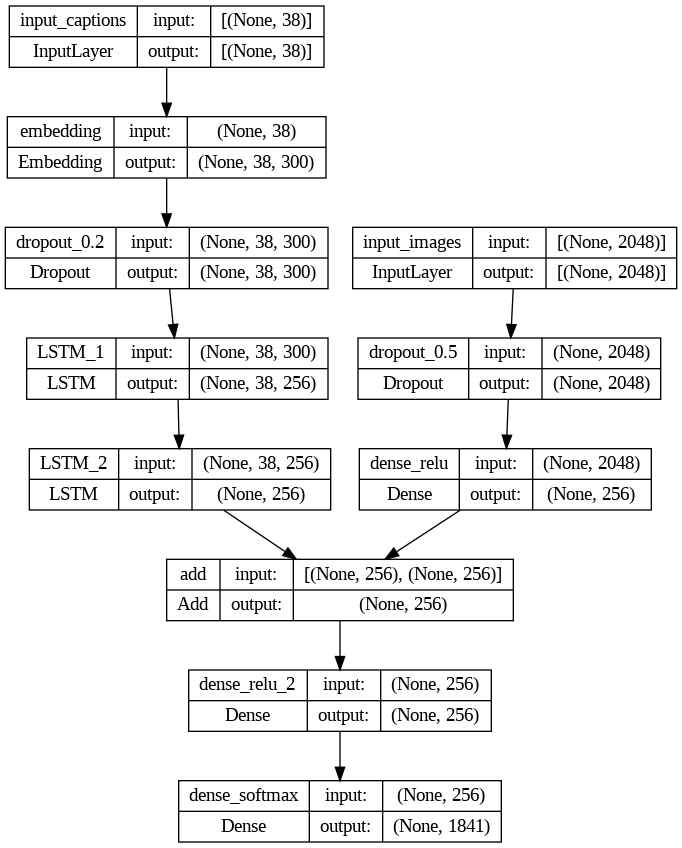

In [ ]:
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)
plot_model(model3, to_file='model3.png', show_shapes=True, show_layer_names=True)

# show a visual of the model
#Image.open('model1.png').show()
Image.open('model2.png').show()
#Image.open('model3.png').show()

# Train Model(s)

In [ ]:
epochs = 10
number_pics_per_batch = 32
steps = len(train_captions)//number_pics_per_batch
val_steps = len(test_captions)//number_pics_per_batch

def train_model(model):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['cosine_proximity'])

  generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
  val_generator = data_generator(test_captions, test_features, word_to_index, max_length_caption, number_pics_per_batch)

  history = model.fit_generator(generator, steps_per_epoch=steps, 
                      validation_data=val_generator, validation_steps=val_steps, 
                      epochs=epochs, verbose=1)
  return history

Running the following code block trains model1 (a single layer LSTM) with the CNN defined in the embedding step.

In [ ]:
# history1 = train_model(model1)

Running the following code block trains model2 (a 2-layer LSTM) with the CNN defined in the embedding step.

In [ ]:
history2 = train_model(model2)

Epoch 1/10
214/214 [==============================] - 87s 362ms/step - loss: 4.6168 - cosine_proximity: 0.2471 - val_loss: 4.0915 - val_cosine_proximity: 0.2883
Epoch 2/10
214/214 [==============================] - 88s 411ms/step - loss: 3.9757 - cosine_proximity: 0.2955 - val_loss: 3.8728 - val_cosine_proximity: 0.3034
Epoch 3/10
214/214 [==============================] - 76s 357ms/step - loss: 3.8097 - cosine_proximity: 0.3061 - val_loss: 3.7902 - val_cosine_proximity: 0.3104
Epoch 4/10
214/214 [==============================] - 76s 353ms/step - loss: 3.7077 - cosine_proximity: 0.3126 - val_loss: 3.7442 - val_cosine_proximity: 0.3151
Epoch 5/10
214/214 [==============================] - 75s 349ms/step - loss: 3.6373 - cosine_proximity: 0.3169 - val_loss: 3.7310 - val_cosine_proximity: 0.3152
Epoch 6/10
214/214 [==============================] - 77s 360ms/step - loss: 3.5825 - cosine_proximity: 0.3202 - val_loss: 3.7225 - val_cosine_proximity: 0.3160
Epoch 7/10
214/214 [==============

Running the following code block trains model3 (a 2-layer GRU) with the CNN defined in the embedding step.

In [ ]:
# history3 = train_model(model3)

The following block prints cosine proximity and loss for training and test data over the 10 epochs. 

{'loss': [4.616762638092041, 3.9756505489349365, 3.8096585273742676, 3.7077157497406006, 3.6372756958007812, 3.5825276374816895, 3.5335192680358887, 3.491347074508667, 3.456745147705078, 3.4233667850494385], 'cosine_proximity': [0.24712049961090088, 0.2954615652561188, 0.30607590079307556, 0.31263047456741333, 0.316940575838089, 0.32021021842956543, 0.32344457507133484, 0.32614651322364807, 0.32847949862480164, 0.3306800425052643], 'val_loss': [4.091457366943359, 3.872819185256958, 3.7901759147644043, 3.7441678047180176, 3.7309815883636475, 3.722538471221924, 3.7188913822174072, 3.7329375743865967, 3.730633020401001, 3.7313714027404785], 'val_cosine_proximity': [0.28826290369033813, 0.3033992052078247, 0.3103843927383423, 0.31510037183761597, 0.31521159410476685, 0.3159649074077606, 0.3166268467903137, 0.31672176718711853, 0.31792131066322327, 0.3177037239074707]}


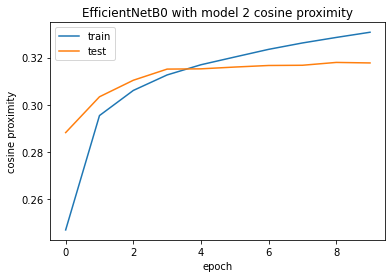

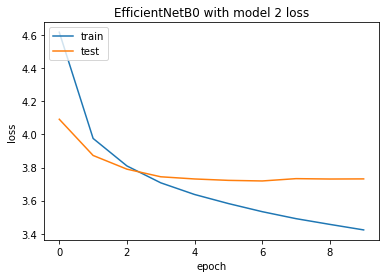

In [ ]:
print(history2.history)

history = history2 # or history1 or history3
plt.figure(1)  
   
# summarize history for accuracy  
plt.figure(1)  
plt.plot(history.history['cosine_proximity'])  
plt.plot(history.history['val_cosine_proximity'])  
plt.title('EfficientNetB0 with model 2 cosine proximity')  
plt.ylabel('cosine proximity')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
plt.figure(2)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('EfficientNetB0 with model 2 loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

Below are the saved histories from our various runs. No single computer could train all the models at once on the CoLab due to RAM limits, so manually saving the histories allows us to plot them together.

In [ ]:
# history for InceptionV3 w/ model 1
history_IV3_model1 = {'loss': [4.583773136138916, 3.970284938812256, 3.8055219650268555, 3.710042715072632, 3.6402573585510254, 3.5861754417419434, 3.539431095123291, 3.498258113861084, 3.4641804695129395, 3.431129217147827], 'cosine_proximity': [0.2501515746116638, 0.295369029045105, 0.3060179352760315, 0.3120763599872589, 0.3165362477302551, 0.3200906217098236, 0.32304617762565613, 0.3257562518119812, 0.3278880715370178, 0.3300648331642151], 'val_loss': [4.083035945892334, 3.879840135574341, 3.8048079013824463, 3.7654976844787598, 3.7524971961975098, 3.7331886291503906, 3.723520040512085, 3.710972309112549, 3.7131571769714355, 3.717241048812866], 'val_cosine_proximity': [0.2877507209777832, 0.30339235067367554, 0.30898740887641907, 0.31170329451560974, 0.31224384903907776, 0.3140820264816284, 0.3151845335960388, 0.31693702936172485, 0.3170628547668457, 0.3168454170227051]}
# history for InceptionV3 w/ model 2
history_IV3_model2 = {'loss': [4.594431400299072, 3.954681158065796, 3.7903213500976562, 3.696896553039551, 3.6263222694396973, 3.570903778076172, 3.5233519077301025, 3.4854531288146973, 3.44639253616333, 3.4114253520965576], 'cosine_proximity': [0.24905575811862946, 0.29716578125953674, 0.3072203993797302, 0.3130630552768707, 0.3174522817134857, 0.3209669291973114, 0.3240858316421509, 0.32646214962005615, 0.3291964530944824, 0.331549733877182], 'val_loss': [4.0857086181640625, 3.8744633197784424, 3.801072835922241, 3.7726757526397705, 3.758126735687256, 3.7521138191223145, 3.751685619354248, 3.7518434524536133, 3.7624292373657227, 3.7613422870635986], 'val_cosine_proximity': [0.2899612784385681, 0.304802268743515, 0.31059572100639343, 0.3126237094402313, 0.31361186504364014, 0.31494998931884766, 0.3153883218765259, 0.316191166639328, 0.31623220443725586, 0.31664684414863586]}
# history for InceptionV3 w/ model 3
history_IV3_model3 ={'loss': [4.502395153045654, 3.9211337566375732, 3.7671353816986084, 3.6759512424468994, 3.607682704925537, 3.551408290863037, 3.503011703491211, 3.4625155925750732, 3.424760341644287, 3.3890886306762695], 'cosine_proximity': [0.25747039914131165, 0.2995173931121826, 0.3089955151081085, 0.3149164915084839, 0.3191169798374176, 0.3226530849933624, 0.32560959458351135, 0.3282565772533417, 0.3307584524154663, 0.3331238329410553], 'val_loss': [4.0224690437316895, 3.8516130447387695, 3.7848806381225586, 3.7443010807037354, 3.73297119140625, 3.7313504219055176, 3.7299201488494873, 3.7290127277374268, 3.7295827865600586, 3.7346317768096924], 'val_cosine_proximity': [0.29528892040252686, 0.30597057938575745, 0.3114023506641388, 0.3151911199092865, 0.31615811586380005, 0.3154122829437256, 0.3163532018661499, 0.3169044852256775, 0.3176286518573761, 0.3176950514316559]}
# history for EfficientNetB0 w/ model 2
history_ENB_model2 = {'loss': [4.5696, 3.8757, 3.6939, 3.5859, 3.5052, 3.4390, 3.3821, 3.3346, 3.2898], 'cosine_proximity': [0.2507, 0.3038, 0.3161, 0.3235, 0.3293, 0.3343, 0.3387, 0.3426, 0.3465, 0.3498], 'val_loss': [4.0075, 3.7903, 3.7074, 3.6674, 3.6463, 3.6342, 3.6324, 3.6273, 3.6346, 3.6377],'val_cosine_proximity': [0.2944, 0.3111, 0.3169, 0.3196, 0.3211, 0.3221, 0.3225, 0.3237, 0.3237, 0.3238]}
# history for ConvNeXtTiny w/ model 2
history_CNT_model2 = {'loss': [4.597991943359375, 3.9155070781707764, 3.722461223602295, 3.6075196266174316, 3.5219502449035645, 3.4571070671081543, 3.4020180702209473, 3.3555777072906494, 3.315582513809204, 3.277611017227173], 'cosine_proximity': [0.2462529093027115, 0.29999038577079773, 0.3128316402435303, 0.32054734230041504, 0.3268001079559326, 0.33151209354400635, 0.3355530798435211, 0.3392966389656067, 0.34250447154045105, 0.34572237730026245], 'val_loss': [4.121677398681641, 3.835557460784912, 3.740278720855713, 3.689197063446045, 3.6649975776672363, 3.651372194290161, 3.643409013748169, 3.6408498287200928, 3.643765926361084, 3.6443257331848145], 'val_cosine_proximity': [0.28420642018318176, 0.30484771728515625, 0.31144285202026367, 0.31596264243125916, 0.31872713565826416, 0.3203284442424774, 0.32130196690559387, 0.3217059075832367, 0.3218501806259155, 0.32178711891174316]}

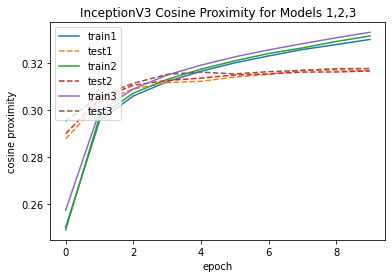

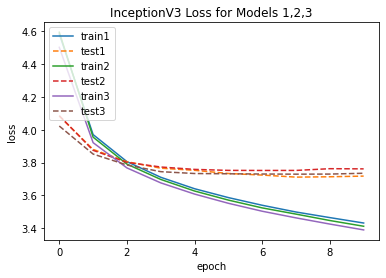

In [ ]:
# summarize history for accuracy  
plt.figure(1)  
plt.plot(history_IV3_model1['cosine_proximity'])  
plt.plot(history_IV3_model1['val_cosine_proximity'], ls='dashed')  
plt.plot(history_IV3_model2['cosine_proximity'])  
plt.plot(history_IV3_model2['val_cosine_proximity'], ls='dashed') 
plt.plot(history_IV3_model3['cosine_proximity'])  
plt.plot(history_IV3_model3['val_cosine_proximity'], ls='dashed')  
plt.title('InceptionV3 Cosine Proximity for Models 1,2,3')  
plt.ylabel('cosine proximity')  
plt.xlabel('epoch')  
plt.legend(['train1', 'test1', 'train2', 'test2', 'train3', 'test3'], loc='upper left')  
  
# summarize history for loss  
plt.figure(2)  
plt.plot(history_IV3_model1['loss'])  
plt.plot(history_IV3_model1['val_loss'], ls='dashed')  
plt.plot(history_IV3_model2['loss'])  
plt.plot(history_IV3_model2['val_loss'], ls='dashed') 
plt.plot(history_IV3_model3['loss'])  
plt.plot(history_IV3_model3['val_loss'], ls='dashed')  
plt.title('InceptionV3 Loss for Models 1,2,3')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train1', 'test1', 'train2', 'test2', 'train3', 'test3'], loc='upper left')  

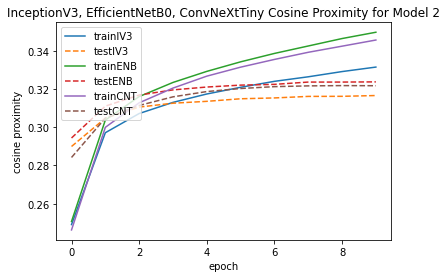

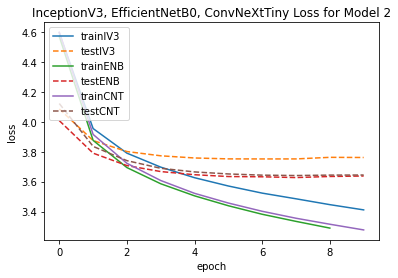

In [ ]:
# summarize history for accuracy  
plt.figure(1)  
plt.plot(history_IV3_model2['cosine_proximity'])  
plt.plot(history_IV3_model2['val_cosine_proximity'], ls='dashed') 
plt.plot(history_ENB_model2['cosine_proximity'])  
plt.plot(history_ENB_model2['val_cosine_proximity'], ls='dashed')  
plt.plot(history_CNT_model2['cosine_proximity'])  
plt.plot(history_CNT_model2['val_cosine_proximity'], ls='dashed')  
plt.title('InceptionV3, EfficientNetB0, ConvNeXtTiny Cosine Proximity for Model 2')  
plt.ylabel('cosine proximity')  
plt.xlabel('epoch')  
plt.legend(['trainIV3', 'testIV3', 'trainENB', 'testENB', 'trainCNT', 'testCNT'], loc='upper left')  

# summarize history for loss  
plt.figure(2)  
plt.plot(history_IV3_model2['loss'])  
plt.plot(history_IV3_model2['val_loss'], ls='dashed') 
plt.plot(history_ENB_model2['loss'])  
plt.plot(history_ENB_model2['val_loss'], ls='dashed')  
plt.plot(history_CNT_model2['loss'])  
plt.plot(history_CNT_model2['val_loss'], ls='dashed')  
plt.title('InceptionV3, EfficientNetB0, ConvNeXtTiny Loss for Model 2')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['trainIV3', 'testIV3', 'trainENB', 'testENB', 'trainCNT', 'testCNT'], loc='upper left')  

<BarContainer object of 3 artists>

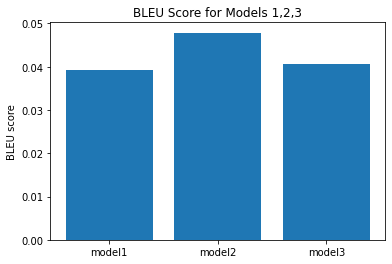

In [ ]:
# Overall accuracy for model1, inceptionV3: 
# context =  0.7831724569227119 ,
# BLEU score =  0.039347300625119166

# Overall accuracy of model 2, inception CNN:
# context =  0.7812299762830239 ,
# 	BLEU score =  0.047869617965495825

# Overall accuracy for model 3, inception CNN: 
# context =  0.7829780409757215 ,
# 	BLEU score =  0.04068652039701058

# Overall accuracy for model2: 
# context =  0.7818301649800314 ,
# BLEU score =  0.045954928713706794

# Overall accuracy for model 2, ConvNeXt Tiny:
# context =  0.788297577110616 ,
# 	BLEU score =  0.04581351657944961


labels = ['model1', 'model2', 'model3']
context_values = [0.7831724569227119,  0.7812299762830239, 0.7829780409757215]
bleu_values = [0.039347300625119166,  0.047869617965495825, 0.04068652039701058]


plt.figure(2)
plt.title('BLEU Score for Models 1,2,3')  
plt.ylabel('BLEU score')  
plt.bar(labels, bleu_values)

<BarContainer object of 3 artists>

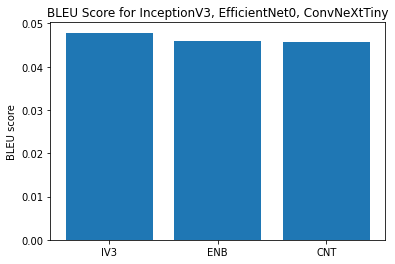

In [ ]:
labels = ['IV3', 'ENB', 'CNT']
bleu_values = [0.047869617965495825,  0.045954928713706794, 0.04581351657944961]

plt.figure(2)
plt.title('BLEU Score for InceptionV3, EfficientNet0, ConvNeXtTiny')  
plt.ylabel('BLEU score')  
plt.bar(labels, bleu_values)

# Testing Model(s) Accuracy

In [ ]:
def predict(model, photo):
    # inputs: the model that is being tested and a test image
    #         (example of a photo input: 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
    # outputs: a generated caption that describes the image

    encoded_photo = encoding_test[photo].reshape((1,-1)) # gets the feature vector representing the
                                                         # image and reshapes the vector from (n,)
                                                         # to (1,n) where n depends on the CNN used
    # generate the caption
    in_text = 'startseq'
    for i in range(max_length_caption):     # limit the caption's maximum length 
        # this loop generates one word at a time and adds it to the predicted caption

        # turn the text into indices
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length_caption)

        # get the word that is most likely to follow the current caption
        yhat = model.predict([encoded_photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        
        # add the word to the current caption
        in_text += ' ' + word

        # if the predicted word is 'endseq', it means the caption is complete
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]         # remove 'startseq' and 'endseq' from the caption
    final = ' '.join(final)
    return final

In [ ]:
def get_cosine_similarity(text1, text2):
  # return the cosine similarity of two texts
  text1 = nlp(text1)
  text2 = nlp(text2)
  return text1.similarity(text2)

def get_bleu_score(actual_captions, output_caption):
 # return the BLEU score of a generated caption
 # actual_captions: array of all the human-provided captions for a given image
 # output_cap: captions given to image from the model
 actual_captions = [cap.split() for cap in actual_captions]
 output_caption = output_caption.split()
 return bleu.sentence_bleu(actual_captions, output_caption)

def accuracy_score(model, photo):
  # return the accuracy scores of a model's generated caption when compared to
  # all 5 human-provided captions of the image
  # inputs: the model that is being tested and a test image
  #         (example of a photo input: 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
  # outputs: a cosine similarity score and a BLEU score
  img_name = photo.split('/')[1].split('.')[0]
  actual_captions = preprocessed_map[img_name] # 5 human-provided captions of the image
  predicted_caption = predict(model, photo)    # the model's generated caption

  # get the cosine similarity score
  acc_context = 0
  for caption in actual_captions:
    acc_context += get_cosine_similarity(predicted_caption, caption)
  acc_context = acc_context / 5                # get the average

  # get the BLEU score
  acc_bleu = get_bleu_score(actual_captions, predicted_caption)

  return acc_context, acc_bleu

The following code block selects a random test image, calls all 3 models to generate a caption, and calculates the cosine proximity and the BLEU score for each generated caption. If you have not trained all 3 models above, comment out the lines which involve the untrained models.

Flicker8k_Dataset/69189650_6687da7280.jpg


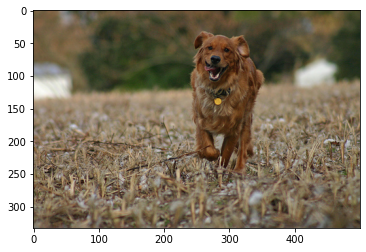

Model 2 caption: a brown dog is running through a path path

Actual captions: 
a brown dog is running through a brown field 
a brown dog is running through the field 
a brown dog with a collar runs in the dead grass with his tongue hanging out to the side 
a brown dog with his tongue wagging as he runs through a field
a dog running in the grass 


Accuracy for model 2: context =  0.8524840773457459 ,
		  BLEU score =  0.7259795291154771


In [ ]:
# testing all models
i = random.randint(0,len(test_img_names))
pic = test_img_names[i]                  # get a random test image
print(pic)                               # print the image's path name
x=plt.imread(pic)
plt.imshow(x)
plt.show()                               # display the image

# display the model's predicted caption
# print("Model 1 caption:", predict(model1, pic))
print("Model 2 caption:", predict(model2, pic))
# print("Model 3 caption:", predict(model3, pic))

# display the 5 human-provided captions for comparison
# img_name = test_img_name[i]
print("\nActual captions: ")
print(*preprocessed_map[test_img_name[i]],sep='\n')
print('\n')

# display the cosine similarity (accuracy_context) and the BLEU score (accuracy_bleu)
# of the predicted caption when compared to the human-provided captions
# accuracy_context, accuracy_bleu = accuracy_score(model1, pic)
# print('Accuracy for model 1: context = ', accuracy_context, \
#       ',\n\t\t  BLEU score = ', accuracy_bleu)
accuracy_context, accuracy_bleu = accuracy_score(model2, pic)
print('Accuracy for model 2: context = ', accuracy_context, \
      ',\n\t\t  BLEU score = ', accuracy_bleu)
accuracy_context, accuracy_bleu = accuracy_score(model3, pic)
# print('Accuracy for model 3: context = ', accuracy_context, \
#       ',\n\t\t  BLEU score = ', accuracy_bleu)

In [ ]:
def overall_accuracy(model):
  # Test the input model's overall accuracy on a total of num_test_pics pictures
  num_test_pics = 500
  accuracy_context = 0
  accuracy_bleu = 0

  # test photos are randomly chosen
  i = random.sample(range(len(test_img_names)), num_test_pics)

  for j in range(num_test_pics):
    pic = test_img_names[i[j]]
    acc_1, acc_2 = accuracy_score(model, pic)
    accuracy_context += acc_1
    accuracy_bleu += acc_2

  accuracy_context /= num_test_pics
  accuracy_bleu /= num_test_pics

  print('Overall accuracy for model: context = ', accuracy_context, \
        ',\n\t\t\t  BLEU score = ', accuracy_bleu)

The following code block calculates average cosine proximity (context) and BLEU score over 500 images. Once again, if you have not trained all 3 models above, comment out the lines which involve the untrained models.

In [ ]:
# overall_accuracy(model1)
overall_accuracy(model2)
# overall_accuracy(model3)

Overall accuracy for model: context =  0.784220945488615 ,
			  BLEU score =  0.03277212077257787
